In [318]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract,contract_path
from tqdm.auto import tqdm
import dacite
import torch
from torch.nn.functional import normalize
from scipy.optimize import curve_fit
import inspect
from functools import partial,wraps,reduce
def _toN(t):
    return t.detach().cpu().tolist()
def _toT(t):
    return torch.as_tensor(t)
def _normalize(t):
    return t/t.norm()
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
torch.cuda.set_device(1)

In [319]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import forward_tensor,forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from HOTRGZ2 import HOTRG_layers,GILT_options,MCF_options
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions,show_asymmetry
from utils import show_matrix,show_tensor_ijkl,show_tensor_ikjl

In [345]:

filename='data/linearized_hotrg_nogilt_graft_tnr_X24_I10'


options=torch.load(filename+'_options.pkl')

(sr,ur)=torch.load(filename+'_eigs_lTRG.pkl')

model=Ising2D()
T0=model.get_T0()
T0_op=model.get_SZT0()

iLayer=options['iLayer']

print(options)

{'tensor_path': 'data/tnr_X24_tensors.pkl', 'max_dim': 24, 'gilt_enabled': False, 'gilt_eps': 8e-07, 'gilt_nIter': 1, 'mcf_enabled': False, 'mcf_eps': 1e-16, 'mcf_max_iter': 20, 'iLayer': 10, 'svd_max_iter': 100, 'svd_tol': 1e-16, 'svd_num_eigvecs': 16, '_version': 2}


In [ ]:

reference_scaling_dimensions=[0.125,1,1.125,2,2.125,3,3.125,4,4.125]
reference_center_charge=.5

show_diff(Ts,stride=2)
#show_diff(fix_gauge.fix_gauges1(Ts,is_HOTRG=True),stride=2)
#show_effective_rank(Ts)
curve=show_scaling_dimensions(Ts,num_scaling_dims=32,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)
show_asymmetry(Ts);

In [343]:


print(options)

print('eigen values')
print(sr)
print('scaling dimensions from linearized TRG')
print(ScalingDimensions.get_scaling_dimensions(sr,scaling=2))
print('central charge from linearized TRG')
print(ScalingDimensions.get_central_charge(sr,scaling=2))

{'tensor_path': 'data/tnr_X24_tensors.pkl', 'max_dim': 24, 'gilt_enabled': False, 'gilt_eps': 8e-07, 'gilt_nIter': 1, 'mcf_enabled': False, 'mcf_eps': 1e-16, 'mcf_max_iter': 20, 'iLayer': 10, 'svd_max_iter': 100, 'svd_tol': 1e-16, 'svd_num_eigvecs': 16, '_version': 2}
eigen values
tensor([0.0021, 0.0019, 0.0012, 0.0011, 0.0011, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0007, 0.0008, 0.0007, 0.0007, 0.0007, 0.0007])
scaling dimensions from linearized TRG
tensor([-0.0000, 0.1896, 0.8545, 0.9580, 0.9575, 1.3982, 1.4511, 1.4521, 1.4604,
        1.4817, 1.5205, 1.5129, 1.5218, 1.5242, 1.5605, 1.5654])
central charge from linearized TRG
tensor(-106.3526)


In [346]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import forward_tensor,forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from HOTRGZ2 import HOTRG_layers,GILT_options,MCF_options
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions,show_asymmetry
from utils import show_matrix,show_tensor_ijkl,show_tensor_ikjl

In [347]:
def show_perturbation_tensor(T_op,u,labels=None,title='', project_out=[],ax=None):
    lT=(T_op.reshape(-1))
    b=lT@u
    for v in project_out:
        bv=_normalize(v.reshape(-1)@u)
        b=b-(b@bv)*bv
    if ax is not None:
        plt.sca(ax)
    plt.title(title)
    plt.bar(range(len(b)),_toN(b),tick_label=labels)
    plt.xticks(rotation = 60)
    plt.axhline(0,color='black')
    if ax is None:
        plt.show()

In [349]:

labels=[f'{d:.3f}' for d in ScalingDimensions.get_scaling_dimensions(sr,scaling=2)]
def NPT(*positions):
    T,T_op,logTotal=forward_observable_tensors(T0,[T0_op]*len(positions),positions,\
                            layers=layers[:iLayer],checkerboard=checkerboard,\
                            cached_Ts=Ts)
    return T_op
def proj(T,out=[]):
    b=T.reshape(-1)@ur
    for v in out:
        bv=v.reshape(-1)@ur;bv/=bv.norm()
        b=b-(b@bv)*bv
    return b
def hist(b,title='',ax=None):
    if ax is not None:
        plt.sca(ax)
    plt.title(title)
    plt.bar(range(len(b)),_toN(b),tick_label=labels)
    plt.xticks(rotation = 60)
    plt.axhline(0,color='black')
    if ax is None:
        plt.show()

In [350]:
lattice_size=2**(iLayer//2)
m=lattice_size//2
d=int(lattice_size*.3)
l,r=m-d,m+d
l1,r1=m-d//2,m+d//2
d1,d2=int(d*np.cos(np.pi/3)),int(d*np.sin(np.pi/3))



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

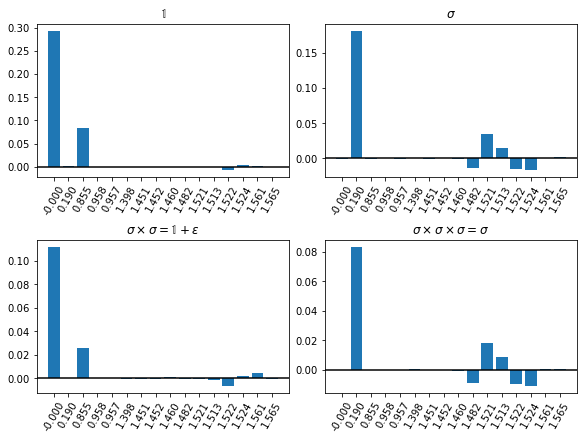

In [351]:
fig, axes = plt.subplots(2,2, constrained_layout=True,figsize=(8,6))

T_id=NPT()
hist(proj(T_id),title=r'$\mathbb{1}$',ax=axes[0,0])

T_1pt=NPT((m,m))
hist(proj(T_1pt),title=r'$\sigma$',ax=axes[0,1])

T_2pt=NPT((l,m),(r,m))
hist(proj(T_2pt),title=r'$\sigma \times \sigma=\mathbb{1}+\epsilon$',ax=axes[1,0])

T_3pt=NPT((m-d1,m-d2),(m-d1,m+d2),(m+d,m))
hist(proj(T_3pt),title=r'$\sigma \times \sigma \times \sigma=\sigma$',ax=axes[1,1])
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

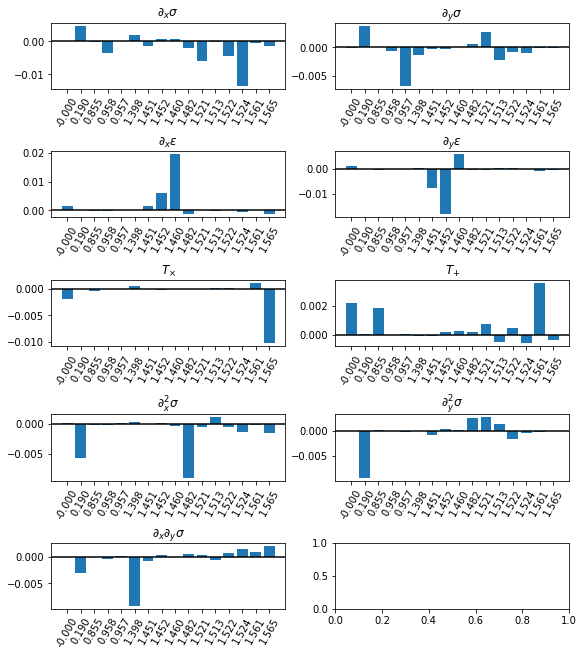

In [352]:




T_dsdx=NPT((r,m))-NPT((l,m))
T_dsdy=NPT((m,r))-NPT((m,l))


T_dedx=NPT((r,l),(r,r))-NPT((l,l),(l,r))
T_dedy=NPT((l,r),(r,r))-NPT((l,l),(r,l))


T_T=NPT((l,l),(r,r))-NPT((l,r),(r,l))
T_T1=NPT((l,m),(r,m))-NPT((m,l),(m,r))
#T_Tbar=T_T

a,b,c,d=NPT((l,m)),NPT((l1,m)),NPT((r1,m)),NPT((r,m))
T_dsdx2=a-b-c+d

a,b,c,d=NPT((m,l)),NPT((m,l1)),NPT((m,r1)),NPT((m,r))
T_dsdy2=a-b-c+d

a,b,c,d=NPT((l,l)),NPT((l,r)),NPT((r,l)),NPT((r,r))
T_dsdxdy=a-b-c+d


fig, axes = plt.subplots(5,2, constrained_layout=True,figsize=(8,9))
hist(proj(T_dsdx),title=r'$\partial_x \sigma$',ax=axes[0,0])
hist(proj(T_dsdy),title=r'$\partial_y \sigma$',ax=axes[0,1])
hist(proj(T_dedx),title=r'$\partial_x \epsilon$',ax=axes[1,0])
hist(proj(T_dedy),title=r'$\partial_y \epsilon$',ax=axes[1,1])
hist(proj(T_T),title=r'$T_{\times}$',ax=axes[2,0])
hist(proj(T_T1),title=r'$T_{+}$',ax=axes[2,1])
hist(proj(T_dsdx2),title=r'$\partial_x^2 \sigma$',ax=axes[3,0])
hist(proj(T_dsdy2),title=r'$\partial_y^2 \sigma$',ax=axes[3,1])
hist(proj(T_dsdxdy),title=r'$\partial_x\partial_y \sigma$',ax=axes[4,0])
plt.show()


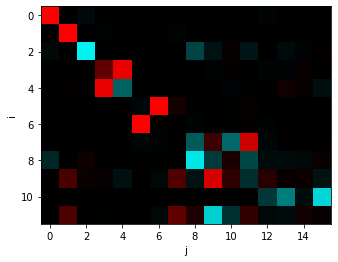

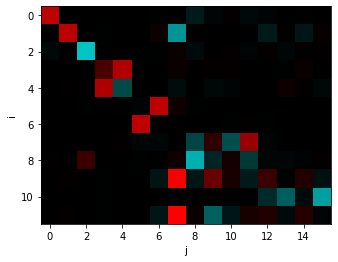

In [329]:
def screen(b,rows):
    b=b.clone()
    for i in range(len(b)):
        if i not in rows:
            b[i]=0
    return b
#Mdot=torch.stack([
#    screen(proj(T_id),[0]),
#    screen(proj(T_1pt),[1]),
#    screen(proj(T_2pt,out=[T_id]),[2]),
#    screen(proj(T_dsdx),[3,4]),
#    screen(proj(T_dsdy),[3,4]),
#    screen(proj(T_dedx),[5,6]),
#    screen(proj(T_dedy),[5,6]),
#    screen(proj(T_T), [8,9]),
#    screen(proj(T_T1),[8,9]),
#    screen(proj(T_dsdx2),  [7,10,11]),
#    screen(proj(T_dsdxdy), [7,10,11]),
#    screen(proj(T_dsdy2),  [7,10,11]),
#])
Mdot=torch.stack([
    proj(T_id),
    proj(T_1pt),
    proj(T_2pt,out=[T_id]),
    proj(T_dsdx),
    proj(T_dsdy),
    proj(T_dedx),
    proj(T_dedy),
    proj(T_T), 
    proj(T_T1),
    proj(T_dsdx2),  
    proj(T_dsdxdy), 
    proj(T_dsdy2),  
])
for i in range(Mdot.shape[0]):
    Mdot[i]/=Mdot[i].norm()
    
    
#Mrot=torch.zeros_like(Mdot)
#Mrot[0,0]=1/Mdot[0,0]
#Mrot[1,1]=1/Mdot[1,1]
#Mrot[2,2]=1/Mdot[2,2]
#Mrot[3:5,3:5]=torch.linalg.inv(Mdot[3:5,3:5]).T
#Mrot[5:7,5:7]=torch.linalg.inv(Mdot[5:7,5:7]).T
#Mrot[7:10,7:12]=torch.linalg.pinv(Mdot[7:10,7:12]).T
Mrot=torch.linalg.pinv(Mdot).T

show_matrix(Mdot.cpu());plt.show()
show_matrix(Mrot.cpu());plt.show()

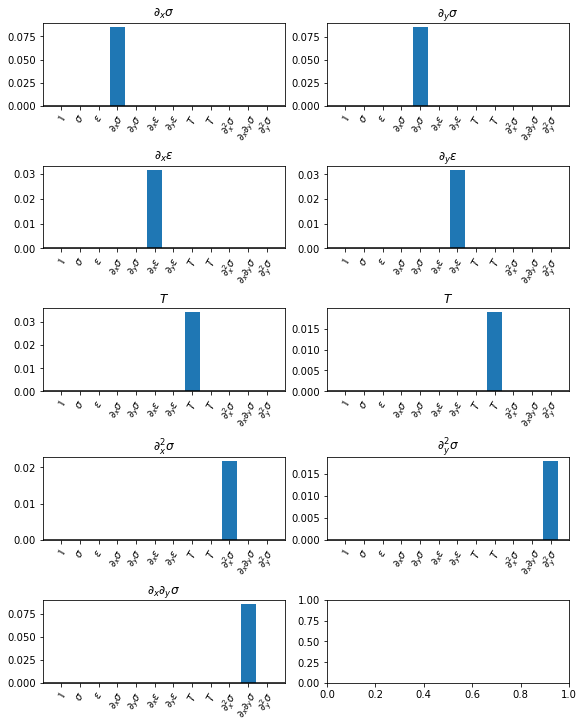

In [330]:
labels1=[
    r'$\mathbb{1}$',
    r'$\sigma$',
    r'$\epsilon$',
    r'$\partial_x \sigma$',
    r'$\partial_y \sigma$',
    r'$\partial_x \epsilon$',
    r'$\partial_y \epsilon$',
    r'$T$',
    r'$T$',
    r'$\partial_x^2 \sigma$',
    r'$\partial_x\partial_y \sigma$',
    r'$\partial_y^2 \sigma$',
]
def hist1(b,title='',ax=None):
    if ax is not None:
        plt.sca(ax)
    plt.title(title)
    plt.bar(range(len(b)),_toN(b),tick_label=labels1)
    plt.xticks(rotation = 60)
    plt.axhline(0,color='black')
    if ax is None:
        plt.show()
        
        
fig, axes = plt.subplots(5,2, constrained_layout=True,figsize=(8,10))
hist1(Mrot@proj(T_dsdx),title=r'$\partial_x \sigma$',ax=axes[0,0])
hist1(Mrot@proj(T_dsdy),title=r'$\partial_y \sigma$',ax=axes[0,1])
hist1(Mrot@proj(T_dedx),title=r'$\partial_x \epsilon$',ax=axes[1,0])
hist1(Mrot@proj(T_dedy),title=r'$\partial_y \epsilon$',ax=axes[1,1])
hist1(Mrot@proj(T_T),title=r'$T$',ax=axes[2,0])
hist1(Mrot@proj(T_T1),title=r'$T$',ax=axes[2,1])
hist1(Mrot@proj(T_dsdx2),title=r'$\partial_x^2 \sigma$',ax=axes[3,0])
hist1(Mrot@proj(T_dsdy2),title=r'$\partial_y^2 \sigma$',ax=axes[3,1])
hist1(Mrot@proj(T_dsdxdy),title=r'$\partial_x\partial_y \sigma$',ax=axes[4,0])
plt.show()

In [331]:
def scan_line(length,stride,direction='x'):
    T0_op=model.get_SZT0()
    T_op_old=None
    data=pd.DataFrame()

    for i in tqdm(range(0,length,stride)):
        x,y={'x':(i,length//2),'y':(length//2,i),'xy':(i,i)}[direction]
        T,T_op,logTotal=forward_observable_tensors(T0,[T0_op],[(x,y)],\
                                layers=layers[:iLayer],checkerboard=checkerboard,\
                                cached_Ts=Ts)
        T_op_norm=_toN(T_op.norm())
        T_op_dot=_toN(T_op.reshape(-1)@ur)
        T_op_normalized_dot=_toN(_normalize(T_op).reshape(-1)@ur)
        #T_op_diff=_toN((T_op1-T_op).norm()/step*length)
        #T_op_normalized_diff=_toN((_normalize(T_op1)-_normalize(T_op)).norm()/step*length)
        #T_op_dot_diff=_toN((T_op1-T_op).reshape(-1)@u/step*length)
        #T_op_normalized_dot_diff=_toN((_normalize(T_op1)-_normalize(T_op)).reshape(-1)@u/step*length)
        corr1=_toN(contract('iikl,IIkl->',T_op,T_op)/contract('iikl,IIkl->',T,T))
        corr2=_toN(contract('ijkk,ijKK->',T_op,T_op)/contract('ijkk,ijKK->',T,T))
        newRow={**params,
                **options,
                'x':x,'y':y,
                'T_op_norm':T_op_norm,
                'T_op_dot':T_op_dot,
                'T_op_normalized_dot':T_op_normalized_dot,
                'corr1':corr1,
                'corr2':corr2,
                #'T_op_diff':T_op_diff,
                #'T_op_normalized_diff':T_op_normalized_diff,
                #'T_op_dot_diff':T_op_dot_diff,
                #'T_op_normalized_dot_diff':T_op_normalized_dot_diff,
               }
        data=data.append(newRow,ignore_index=True)
        T_op_old=T_op
    return data

In [332]:
data_scan_line=scan_line(length=lattice_size,stride=max(1,lattice_size//128),direction='x')

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

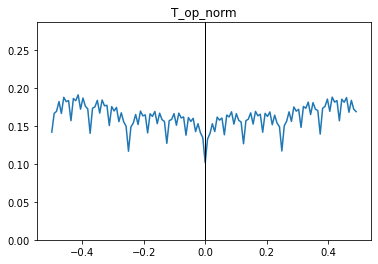

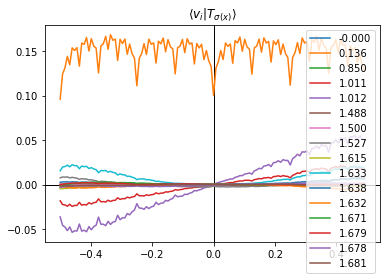

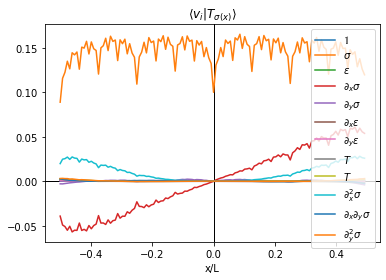

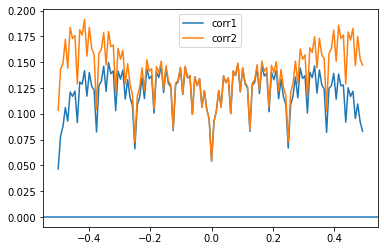

In [333]:
tdu=np.array(data_scan_line['T_op_dot'].to_list()).T
tn=data_scan_line['T_op_norm']
data_scan_line['xmod']=data_scan_line['x']/lattice_size-.5

plt.plot(data_scan_line['xmod'],tn)
plt.axhline(0,color='black',lw=1)
plt.axvline(0,color='black',lw=1)
plt.ylim([0,tn.max()*1.5])
plt.title('T_op_norm')
plt.show()

plt.axhline(0,color='black',lw=1)
plt.axvline(0,color='black',lw=1)
for i in range(tdu.shape[0]):
    plt.plot(data_scan_line['xmod'],tdu[i],label=labels[i])
plt.title(r'$\langle v_i | T_{\sigma(x)} \rangle$')
plt.legend()
plt.show()

plt.axhline(0,color='black',lw=1)
plt.axvline(0,color='black',lw=1)
tdurot=_toN(Mrot)@tdu
for i in range(tdurot.shape[0]):
    plt.plot(data_scan_line['xmod'],tdurot[i],label=labels1[i])
plt.xlabel('x/L')
#plt.ylabel(r'$\langle v_i | T_{\sigma(x)} \rangle$')
plt.title(r'$\langle v_i | T_{\sigma(x)} \rangle$')
plt.legend()
plt.show()

plt.plot(data_scan_line['xmod'],data_scan_line['corr1'],label='corr1')
plt.plot(data_scan_line['xmod'],data_scan_line['corr2'],label='corr2')
plt.axhline(0)
plt.legend()
plt.show()

In [334]:
coeff1=np.polyfit(x=data_scan_line['xmod'],y=tdurot[3],deg=1)[0]
coeff2=np.polyfit(x=data_scan_line['xmod'],y=tdurot[9],deg=2)[0]
print(coeff1,coeff2)

Os=(Mrot@ur.T)
def fake_T():
    T=Os[0].clone()
    bond_dim=round(T.shape[0]**.25)
    T=T.reshape((bond_dim,)*4)
    return T
def fake_Tsigma(x,y):
    T=Os[1].clone()
    T=T+coeff1*(x*Os[3]+y*Os[4])
    T=T+coeff2*(x*x*Os[9]+2*x*y*Os[10]+y*y*Os[11])
    bond_dim=round(T.shape[0]**.25)
    T=T.reshape((bond_dim,)*4)
    return T

0.12479436468268433 0.12373958826565819


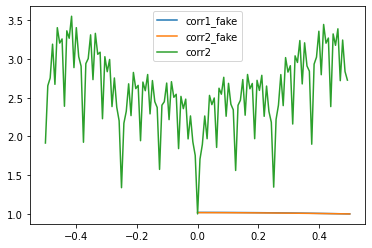

In [335]:

def scan_line_fake(length):
    data=pd.DataFrame()
    for x in np.linspace(0,length):
        T=fake_T()
        T1=fake_Tsigma(x,0)
        T2=fake_Tsigma(x,0)
        corr1=_toN(contract('iikl,IIkl->',T1,T1)/contract('iikl,IIkl->',T,T))
        corr2=_toN(contract('ijkk,ijKK->',T1,T1)/contract('iikl,IIkl->',T,T))
        newRow={'x':x,'corr1':corr1,'corr2':corr2}
        data=data.append(newRow,ignore_index=True)
    return data
data_scan_line_fake=scan_line_fake(length=.5)
plt.plot(data_scan_line_fake['x'],data_scan_line_fake['corr1']/data_scan_line_fake['corr1'].min(),label='corr1_fake')
plt.plot(data_scan_line_fake['x'],data_scan_line_fake['corr2']/data_scan_line_fake['corr2'].min(),label='corr2_fake')
plt.plot(data_scan_line['xmod'],data_scan_line['corr2']/data_scan_line['corr2'].min(),label='corr2')
plt.legend()
plt.show()

# What if the operator insertion goes to Boundary?

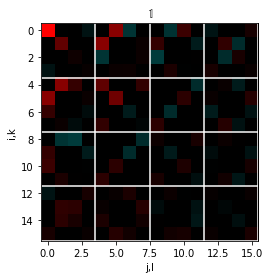

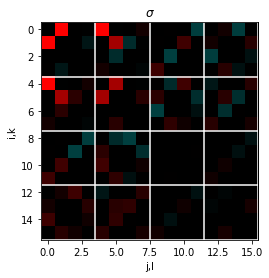

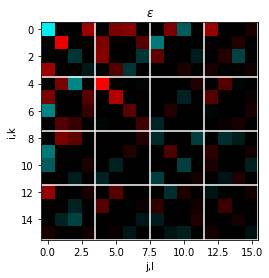

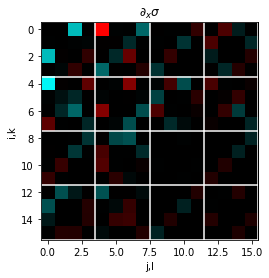

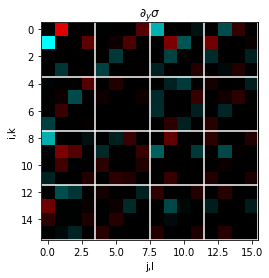

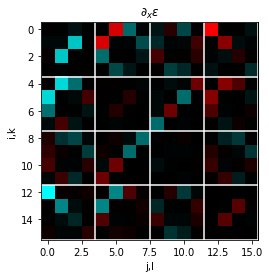

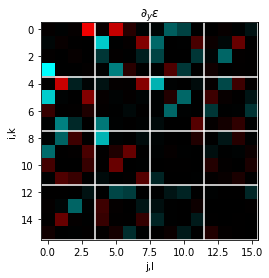

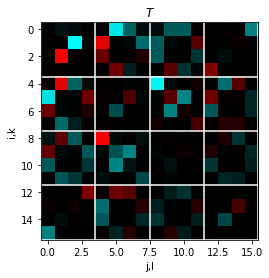

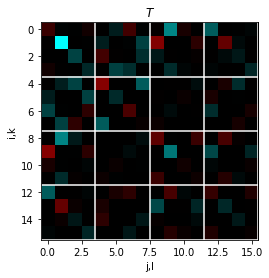

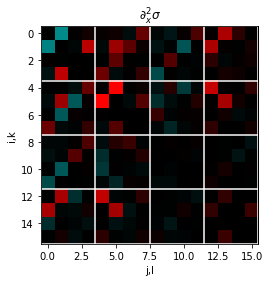

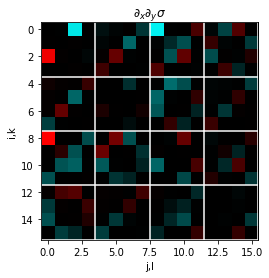

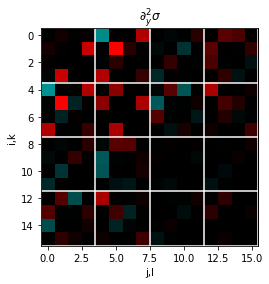

In [217]:
for i,O in enumerate(Os):
    plt.title(labels1[i])
    show_tensor_ikjl(O.reshape(30,30,30,30).cpu(),max_dim=4)
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

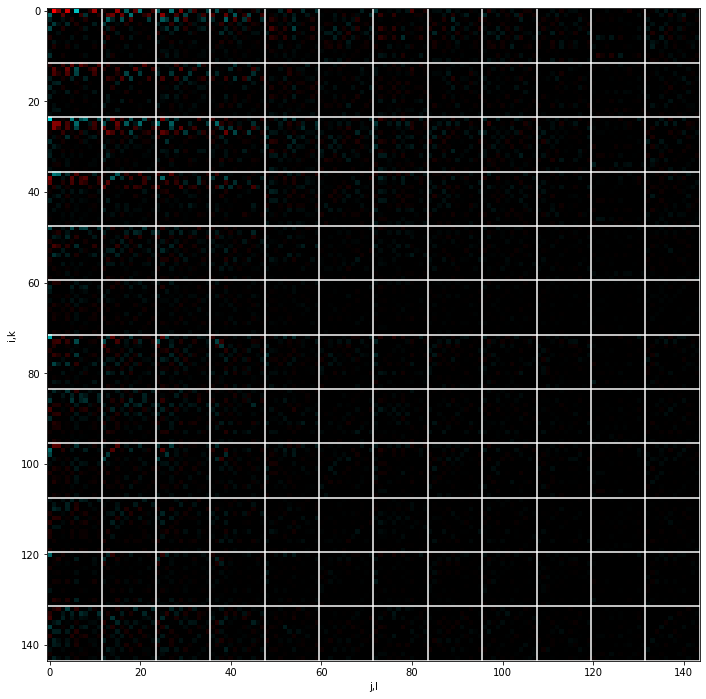

In [235]:
def get_sigma(x):
    T0=model.get_T0()
    T0_op=model.get_SZT0()
    T,T_op,logTotal=forward_observable_tensors(T0,[T0_op],[(x,lattice_size//2)],\
                            layers=layers[:iLayer],checkerboard=checkerboard,\
                            cached_Ts=Ts)
    return T_op

import math
def get_dnsigma(x,n):
    rtval=0
    for i in range(n+1):
        rtval+=get_sigma(x+i)*math.comb(n,i)*(-1)**i
    return rtval
    
plt.figure(figsize=(12,12))
show_tensor_ikjl(get_dnsigma(x=511,n=12).cpu(),max_dim=12)
plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

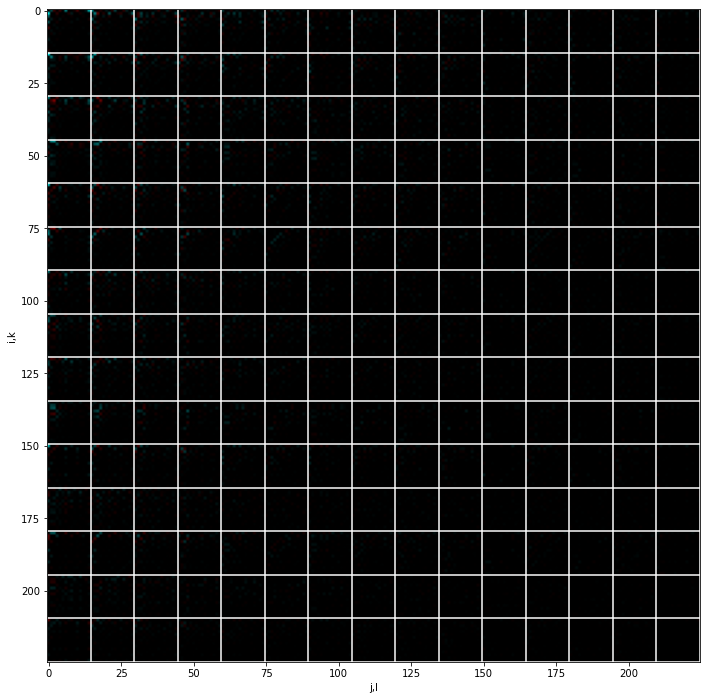

In [237]:
plt.figure(figsize=(12,12))
show_tensor_ikjl(get_dnsigma(x=511,n=6).cpu(),max_dim=15)
plt.show()

In [199]:
v=torch.ones(3)
v*v@v

tensor(3.)

In [ ]:
def project_out(T,Os):
    v=T.flatten()
    for o in Os:
        o=o/o.norm()
        v=v-(v@o)*o
    return v
print(T_op.norm())
T_op_out=project_out(T_op,Os)
print(T_op_out.norm())